In [1]:
import sys 
import numpy as np
import h5py 
import copy
from multiprocessing import Pool, cpu_count
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.patches import Patch, Rectangle, Arrow, FancyArrow
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import itertools
%matplotlib inline

import gpder
from gpder import GaussianProcessRegressor
from gpder.gaussian_process.kernels import RegularKernel
from gpder.gaussian_process.kernels import DerivativeKernel
from gpder import GPUncertaintyOptimizer, NetVarianceLoss

In [2]:
f = h5py.File("../../demos/HEP_2D/three_jets_30k.h5", "r")
J1_threeM = np.array(f["j1_threeM"])
J2_threeM = np.array(f["j2_threeM"])
J3_threeM = np.array(f["j3_threeM"])
threeM = np.stack((J1_threeM, J2_threeM, J3_threeM), axis=1)
f.close()

/tmp/ipykernel_1523630/34128670.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  J1_threeM = np.array(f["j1_threeM"])
/tmp/ipykernel_1523630/34128670.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  J2_threeM = np.array(f["j2_threeM"])
/tmp/ipykernel_1523630/34128670.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  J3_threeM = np.array(f["j3_threeM"])


In [3]:
import sys
sys.path.append("../../demos/HEP_4D")

from hep_functions import efficiency
from hep_functions import der_efficiency

def efficiency_events(X, threeM=threeM, normalized=True):
    return efficiency(X, events_threeM=threeM, normalized=normalized)

def der_efficiency_events_sigmoid10(X, threeM=threeM):
    return der_efficiency(X, events_threeM=threeM, a=1/10)

# Figure 13

In [4]:
eta_J23 = np.vstack((J2_threeM[:, 1], J3_threeM[:, 1])).T
pT_J23 = np.vstack((J2_threeM[:, 0], J3_threeM[:, 0])).T
eta_avg_J23 = np.average(eta_J23, weights=pT_J23, axis=1)

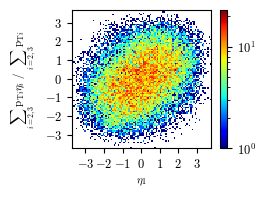

In [5]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 9,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

my_cmap = plt.cm.jet
my_cmap.set_under('w',1)
plt.figure(figsize=((3+3/8)/1.5, 1.8))
plt.hist2d(J1_threeM[:, 1], eta_avg_J23, bins=100, norm=LogNorm(), cmap=my_cmap)
plt.colorbar()
plt.xticks([-3, -2, -1, 0, 1, 2, 3])
plt.yticks([-3, -2, -1, 0, 1, 2, 3])
plt.xlabel(r"$\eta_{1}$", fontsize=8)
plt.ylabel(r"$\sum_{i=2, 3} \mathrm{p}_{\mathrm{T}i} \eta_i ~/~ \sum_{i=2, 3} \mathrm{p}_{\mathrm{T}i}$",
           fontsize=8)

plt.savefig("eta_dist.pdf", bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 14

In [6]:
# -- testing -- # 
res = 25
X_lower = 0.5
X_upper = 1.5
lin = np.linspace(X_lower, X_upper, res)
nuJ1_in, nuJ1_out, nuJ23_in, nuJ23_out = np.meshgrid(lin, lin, lin, lin)
X_test = np.vstack((nuJ1_in.flatten(), nuJ1_out.flatten(), 
                    nuJ23_in.flatten(), nuJ23_out.flatten())).T
y_test = Pool(cpu_count()).map(efficiency_events, X_test)
y_test = np.array(y_test).reshape(-1,)
# ------------- # 

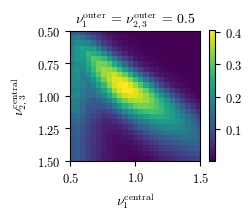

In [7]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 9,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

params_labels = [r'$\nu_{1}^{\mathrm{central}}$',
                 r'$\nu_{1}^{\mathrm{outer}}$',
                 r'$\nu_{2,3}^{\mathrm{central}}$',
                 r'$\nu_{2,3}^{\mathrm{outer}}$']
combinations = list(itertools.combinations(np.arange(4), 2))
plt.figure(figsize=(2.1, 1.7))
hold_val = 0.5
res = res
ix = np.where((X_test[:, 1] == hold_val) & (X_test[:, 3] == hold_val))
y_test_quad = y_test[ix].reshape(res, res)
plt.imshow(y_test_quad, extent=[X_lower, X_upper, X_upper, X_lower])
plt.colorbar()
plt.title("{} = {} = {}".format(params_labels[1], params_labels[3], hold_val), fontsize=10)
plt.xlabel(params_labels[0], fontsize=10)
plt.ylabel(params_labels[2], fontsize=10)
plt.xlim(0.5, 1.5)
plt.ylim(1.5, 0.5)
plt.yticks([0.5, 0.75, 1.0, 1.25, 1.5])
plt.savefig('hep4d_truth.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 15

In [8]:
def efficiency_unnormalized(X):
    return efficiency_events(X, normalized=False)

def generate_X_onaxis(res):
    X_coords = np.linspace(np.repeat(X_lower, 4), np.repeat(X_upper, 4), res)
    n = len(X_coords)
    X_grid = np.ones((n*4, 4))
    for i in range(4):
        X_grid[i*n:(i+1)*n, i] = X_coords[:, i]
    X_grid_set = set()
    for x in X_grid:
        tupl = tuple(x)
        if tupl not in X_grid_set:
            X_grid_set.add(tupl)
    return np.array(list(X_grid_set))

In [9]:
X_onaxis = generate_X_onaxis(res=25)
y_onaxis = Pool(cpu_count()).map(efficiency_unnormalized, X_onaxis)
y_onaxis = np.array(y_onaxis).reshape(-1,)

def onaxis_regression(X, X_onaxis=X_onaxis, y_onaxis=y_onaxis):
    nuJ1_in, nuJ23_in, nuJ1_out, nuJ23_out = X[0], X[1], X[2], X[3]
    nuJ1_in_ix   = np.where((X_onaxis[:, 0] == nuJ1_in) & (X_onaxis[:, 1] == 1)        & (X_onaxis[:, 2] == 1)        & (X_onaxis[:, 3] == 1))
    nuJ23_in_ix  = np.where((X_onaxis[:, 0] == 1)       & (X_onaxis[:, 1] == nuJ23_in) & (X_onaxis[:, 2] == 1)        & (X_onaxis[:, 3] == 1))
    nuJ1_out_ix  = np.where((X_onaxis[:, 0] == 1)       & (X_onaxis[:, 1] == 1)        & (X_onaxis[:, 2] == nuJ1_out) & (X_onaxis[:, 3] == 1))
    nuJ23_out_ix = np.where((X_onaxis[:, 0] == 1)       & (X_onaxis[:, 1] == 1)        & (X_onaxis[:, 2] == 1)        & (X_onaxis[:, 3] == nuJ23_out))
    return y_onaxis[nuJ1_in_ix] * y_onaxis[nuJ23_in_ix] * y_onaxis[nuJ1_out_ix] * y_onaxis[nuJ23_out_ix]

y_OAR = Pool(cpu_count()).map(onaxis_regression, X_test)
y_OAR = np.array(y_OAR).reshape(-1,)

# making sure the on-axis regression are the equal to the true values
# this is easier than using if statements in the onaxis_regression function 
for i, x in enumerate(X_onaxis):
    ix = np.where((X_test[:, 0] == x[0]) & (X_test[:, 1] == x[1]) & (X_test[:, 2] == x[2]) & (X_test[:, 3] == x[3]))
    y_OAR[ix] = y_onaxis[i]

# normalization
norm = efficiency_unnormalized((1, 1, 1, 1))
y_OAR /= norm

mse_OAR = np.mean((y_OAR.ravel() - y_test.ravel())**2)

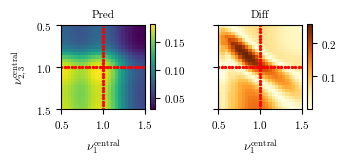

In [10]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 1.3), sharey=True)
plt.subplots_adjust(wspace=0.5)

params_labels = [r'$\nu_{1}^{\mathrm{central}}$',
                 r'$\nu_{1}^{\mathrm{outer}}$',
                 r'$\nu_{2,3}^{\mathrm{central}}$',
                 r'$\nu_{2,3}^{\mathrm{outer}}$']
combinations = list(itertools.combinations(np.arange(4), 2))
hold_val = 0.5
res = res
ix = np.where((X_test[:, 1] == hold_val) & (X_test[:, 3] == hold_val))

# -- prediction -- #
y_test_quad = y_OAR[ix].reshape(res, res)
im0 = ax[0].imshow(y_test_quad, extent=[X_lower, X_upper, X_upper, X_lower])
plt.colorbar(im0, ax=ax[0], shrink=0.85)
# ax[0].text(0.64, 0.2, "Prediction", fontsize=8)
# ax[0].set_title("{}, {} = {}".format(params_labels[1], params_labels[3], hold_val), fontsize=8)
ax[0].set_title("Pred", fontsize=8)
ax[0].set_xlabel(params_labels[0], fontsize=9)
ax[0].set_ylabel(params_labels[2], fontsize=9)
ax[0].set_xlim(0.5, 1.5)
ax[0].set_ylim(1.5, 0.5)
ax[0].scatter(X_onaxis[:, 1], X_onaxis[:, 3], color='red', s=2, label='Observations')


# -- Difference -- #
y_test_quad = np.abs(y_OAR[ix] - y_test[ix]).reshape(res, res)
im1 = ax[1].imshow(y_test_quad, extent=[X_lower, X_upper, X_upper, X_lower], cmap='YlOrBr')
plt.colorbar(im1, ax=ax[1], shrink=0.85)
# ax[1].text(0.9, 0.2, "Diff", fontsize=8)
# ax[1].set_title("{}, {} = {}".format(params_labels[1], params_labels[3], hold_val), fontsize=8)
ax[1].set_title("Diff", fontsize=8)
ax[1].set_xlabel(params_labels[0], fontsize=9)
# ax[1].set_ylabel(params_labels[2], fontsize=8)
ax[1].set_xlim(0.5, 1.5)
ax[1].set_ylim(1.5, 0.5)
ax[1].scatter(X_onaxis[:, 1], X_onaxis[:, 3], color='red', s=2, label='Observations')

plt.savefig('hep4d_onaxis.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 16 (a)

In [11]:
amplitude = np.sqrt(0.1)
length_scale = 0.25
noise_level = np.sqrt(1e-4)
noise_level_der = np.sqrt(10)
n_restarts_optimizer = 3  # More improves the results but just slightly and it is $$$

In [12]:
def generate_training_grid(res):
    cent_val = (X_lower+X_upper) / 2.0
    st = 0.2
    X_coords = np.linspace(np.repeat(X_lower, 4)+st, np.repeat(X_upper, 4)-st, res)
    n = len(X_coords)
    X_grid = np.ones((n*4, 4)) * cent_val
    for i in range(4):
        X_grid[i*n:(i+1)*n, i] = X_coords[:, i]
    X_grid_set = set()
    for x in X_grid:
        tupl = tuple(x)
        if tupl not in X_grid_set:
            X_grid_set.add(tupl)
    return np.array(list(X_grid_set))

# -- trainig -- #
X_train = generate_training_grid(res=3)
y_train = Pool(cpu_count()).map(efficiency_events, X_train)
y_train = np.array(y_train).reshape(-1,)
dy_train = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_train)
dy_train = np.array(dy_train).reshape(-1, 4)
# ------------- #

In [13]:
def fill_image(image, ax, title, preds=False, X_train=None, cmap='viridis', vmin=0, vmax=1, cbarticks=None):

    extent = [0.5, 1.5, 1.5, 0.5]
    im = ax.imshow(image, origin='upper', extent=extent, cmap=cmap, 
                #    vmin=vmin, vmax=vmax
                   )
    cbar = plt.colorbar(im, ax=ax, shrink=0.6, ticks=cbarticks)
    cbar.ax.tick_params(labelsize=8, pad=1)
    cbar.formatter.set_powerlimits((0, 0))
    cbar.ax.yaxis.set_offset_position('left')    
    if X_train is not None:
        if X_train.shape[0] > 9:
            ax.scatter(X_train[:9, 0], X_train[:9, 1], color='#FA0000', s=2, label='Initial obs.')
            ax.scatter(X_train[9:, 0], X_train[9:, 1], color='#FB56F6', s=2, label='Bayes obs.')
        else:
            ax.scatter(X_train[:9, 0], X_train[:9, 1], color='#FA0000', s=2, label='Observations')
    ax.set_title(title, pad=3)
    ax.set_xlabel(r'$\nu_{1}^{\mathrm{central}}$', fontsize=8, labelpad=0.5)
    if preds:
        ax.set_ylabel(r'$\nu_{2,3}^{\mathrm{central}}$', fontsize=8, labelpad=0.5)
    ax.tick_params(axis='both', which='major')
    ax.set_xlim(0.5, 1.5)
    ax.set_ylim(1.5, 0.5)
    ax.tick_params(axis='both', labelsize=7, which='major', pad=1)
    return im

In [14]:
def batch_predict(gp, X_test, batch_size=256):
    n_batches = X_test.shape[0] // batch_size
    y_pred = np.zeros(X_test.shape[0])
    std_pred = np.zeros(X_test.shape[0])
    for i in range(n_batches):
        start = i*batch_size
        end = (i+1)*batch_size
        mu, std = gp.predict(X_test[start:end], return_std=True)
        y_pred[start:end] = mu.ravel()
        std_pred[start:end] = std.ravel()
    return y_pred, std_pred

0.316**2 * RBF(length_scale=0.25) + WhiteKernel(noise_level=0.01)
MSE: 0.0801


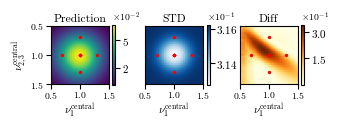

In [15]:
kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_reg.fit(X_train, y_train)
print(gp_reg.kernel)

y_pred, y_std = batch_predict(gp_reg, X_test)
mse = np.mean((y_test.ravel() - y_pred.ravel())**2)
print("MSE: {:.4f}".format(mse))

plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 3, figsize=(3+3/8, 1.3), sharey=True)
plt.subplots_adjust(wspace=0.3)

params_labels = [r'$\nu_{1}^{\mathrm{central}}$',
                 r'$\nu_{1}^{\mathrm{outer}}$',
                 r'$\nu_{2,3}^{\mathrm{central}}$',
                 r'$\nu_{2,3}^{\mathrm{outer}}$']
combinations = list(itertools.combinations(np.arange(4), 2))
hold_val = 0.5
ix = np.where((X_test[:, 1] == hold_val) & (X_test[:, 3] == hold_val))

im0 = fill_image(y_pred[ix].reshape(res, res), ax[0], 
                 X_train=gp_reg.X_train[:, 1:4:2], preds=True, 
                 title="Prediction", 
                 vmin=0, vmax=0.06, 
                 cbarticks=[0.02, 0.05]
                 )
im1 = fill_image(y_std[ix].reshape(res, res), ax[1], 
                 X_train=gp_reg.X_train[:, 1:4:2], 
                 title="STD", cmap='Blues', 
                 vmin=0, vmax=0.32, 
                 cbarticks=[0.314, 0.316]
                 )
diff = np.abs(y_test[ix] - y_pred[ix].ravel())
im2 = fill_image(diff.reshape(res, res), ax[2], 
                 X_train=gp_reg.X_train[:, 1:4:2], 
                 title="Diff", cmap='YlOrBr', 
                 vmin=0, vmax=0.35, 
                 cbarticks=[0, 0.15, 0.3]
                 )

ax[1].tick_params(axis='y', left=False)
ax[2].tick_params(axis='y', left=False)

plt.savefig('hep4d_regGPR.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 16 (b)

0.316**2 * DerivativeRBF(length_scale=0.25) + WhiteKernel(noise_level=0.01) + WhiteKernel_der(noise_level=3.16)
MSE: 0.0782


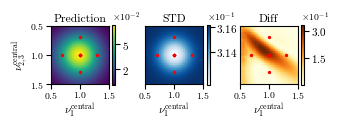

In [16]:
kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
gp_der.fit(X_train, y_train, X_train, dy_train)
print(gp_der.kernel)

y_pred, y_std = batch_predict(gp_der, X_test)
mse = np.mean((y_test.ravel() - y_pred.ravel())**2)
print("MSE: {:.4f}".format(mse))

plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 7,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 3, figsize=(3+3/8, 1.3), sharey=True)
plt.subplots_adjust(wspace=0.3)

params_labels = [r'$\nu_{1}^{\mathrm{central}}$',
                 r'$\nu_{1}^{\mathrm{outer}}$',
                 r'$\nu_{2,3}^{\mathrm{central}}$',
                 r'$\nu_{2,3}^{\mathrm{outer}}$']
combinations = list(itertools.combinations(np.arange(4), 2))
hold_val = 0.5
ix = np.where((X_test[:, 1] == hold_val) & (X_test[:, 3] == hold_val))

im0 = fill_image(y_pred[ix].reshape(res, res), ax[0], 
                 X_train=gp_der.X_train[:, 1:4:2], preds=True, 
                 title="Prediction", 
                 vmin=0, vmax=0.06, 
                 cbarticks=[0.02, 0.05]
                 )
im1 = fill_image(y_std[ix].reshape(res, res), ax[1], 
                 X_train=gp_der.X_train[:, 1:4:2], 
                 title="STD", cmap='Blues', 
                 vmin=0, vmax=0.32, 
                 cbarticks=[0.314, 0.316]
                 )
diff = np.abs(y_test[ix] - y_pred[ix].ravel())
im2 = fill_image(diff.reshape(res, res), ax[2], 
                 X_train=gp_der.X_train[:, 1:4:2], 
                 title="Diff", cmap='YlOrBr', 
                 vmin=0, vmax=0.35, 
                 cbarticks=[0, 0.15, 0.3]
                 )

ax[1].tick_params(axis='y', left=False)
ax[2].tick_params(axis='y', left=False)



plt.savefig('hep4d_derGPR.pdf', bbox_inches="tight", pad_inches=0.03, dpi=400)
plt.show()

# Figure 17 (a)

In [17]:
def BED_regGP(X_util_dim, gamma, n):
    # -- Utility input --------------------------------------------------------- #
    lin = np.linspace(X_lower, X_upper, X_util_dim)
    nuJ1_in, nuJ1_out, nuJ23_in, nuJ23_out = np.meshgrid(lin, lin, lin, lin)
    X_util = np.vstack((nuJ1_in.flatten(), nuJ1_out.flatten(), 
                        nuJ23_in.flatten(), nuJ23_out.flatten())).T
    # -------------------------------------------------------------------------- #

    gp_reg_mse = np.zeros((n, 89))
    gp_reg_uncert = np.zeros((n, 89))

    for i in range(n):
        kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
        gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42+i)
        gp_reg.fit(X_train, y_train)

        y_pred, std = batch_predict(gp_reg, X_test)
        gp_reg_mse[i, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_reg_uncert[i, 0] = np.sum(std.ravel()**2)

        params_dicc = {'nuJ1_in': (X_lower, X_upper), 'nuJ1_out': (X_lower, X_upper),
                    'nuJ23_in': (X_lower, X_upper), 'nuJ23_out': (X_lower, X_upper)}
        BED_reg = GPUncertaintyOptimizer(
            gp_model=gp_reg,
            bounds=params_dicc,
            function=efficiency_events,
            random_state=42+i,
            verbose=False,
        )

        for j in range(88):
        # for j in range(1):
            gp_reg = BED_reg.minimize_variance(
                X_util=X_util, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=gamma,
            )
            y_pred, std = batch_predict(gp_reg, X_test)
            gp_reg_mse[i, j+1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
            gp_reg_uncert[i, j+1] = np.sum(std.ravel()**2)
    return gp_reg_mse, gp_reg_uncert
    

In [18]:
# gp_reg_mse_Xu3_g5, gp_reg_uncert_Xu3_g5 = BED_regGP(X_util_dim=3, gamma=np.sqrt(1/5), n=5)
# gp_reg_mse_Xu3_g0, gp_reg_uncert_Xu3_g0 = BED_regGP(X_util_dim=3, gamma=0, n=5)

# gp_reg_mse_Xu5_g10, gp_reg_uncert_Xu5_g10 = BED_regGP(X_util_dim=5, gamma=np.sqrt(1/10), n=5)
# gp_reg_mse_Xu5_g0, gp_reg_uncert_Xu5_g0 = BED_regGP(X_util_dim=5, gamma=0, n=5)

# gp_reg_mse_Xu10_g50, gp_reg_uncert_Xu10_g50 = BED_regGP(X_util_dim=10, gamma=np.sqrt(1/50), n=5)
# gp_reg_mse_Xu10_g0, gp_reg_uncert_Xu10_g0 = BED_regGP(X_util_dim=10, gamma=0, n=5)

In [19]:
# f = h5py.File("./gp_reg_mse_uncert.h5", "w")
# # X_util_dim = 3
# f.create_dataset("gp_reg_mse_Xu3_g5", data=gp_reg_mse_Xu3_g5)
# f.create_dataset("gp_reg_uncert_Xu3_g5", data=gp_reg_uncert_Xu3_g5)
# f.create_dataset("gp_reg_mse_Xu3_g0", data=gp_reg_mse_Xu3_g0)
# f.create_dataset("gp_reg_uncert_Xu3_g0", data=gp_reg_uncert_Xu3_g0)
# # X_util_dim = 5
# f.create_dataset("gp_reg_mse_Xu5_g10", data=gp_reg_mse_Xu5_g10)
# f.create_dataset("gp_reg_uncert_Xu5_g10", data=gp_reg_uncert_Xu5_g10)
# f.create_dataset("gp_reg_mse_Xu5_g0", data=gp_reg_mse_Xu5_g0)
# f.create_dataset("gp_reg_uncert_Xu5_g0", data=gp_reg_uncert_Xu5_g0)
# # X_util_dim = 10
# f.create_dataset("gp_reg_mse_Xu10_g50", data=gp_reg_mse_Xu10_g50)
# f.create_dataset("gp_reg_uncert_Xu10_g50", data=gp_reg_uncert_Xu10_g50)
# f.create_dataset("gp_reg_mse_Xu10_g0", data=gp_reg_mse_Xu10_g0)
# f.create_dataset("gp_reg_uncert_Xu10_g0", data=gp_reg_uncert_Xu10_g0)
# f.close()

In [20]:
f = h5py.File("./gp_reg_mse_uncert.h5", "r")
gp_reg_mse_Xu3_g5 = np.array(f["gp_reg_mse_Xu3_g5"])
gp_reg_uncert_Xu3_g5 = np.array(f["gp_reg_uncert_Xu3_g5"])
gp_reg_mse_Xu3_g0 = np.array(f["gp_reg_mse_Xu3_g0"])
gp_reg_uncert_Xu3_g0 = np.array(f["gp_reg_uncert_Xu3_g0"])
gp_reg_mse_Xu5_g10 = np.array(f["gp_reg_mse_Xu5_g10"])
gp_reg_uncert_Xu5_g10 = np.array(f["gp_reg_uncert_Xu5_g10"])
gp_reg_mse_Xu5_g0 = np.array(f["gp_reg_mse_Xu5_g0"])
gp_reg_uncert_Xu5_g0 = np.array(f["gp_reg_uncert_Xu5_g0"])
gp_reg_mse_Xu10_g50 = np.array(f["gp_reg_mse_Xu10_g50"])
gp_reg_uncert_Xu10_g50 = np.array(f["gp_reg_uncert_Xu10_g50"])
gp_reg_mse_Xu10_g0 = np.array(f["gp_reg_mse_Xu10_g0"])
gp_reg_uncert_Xu10_g0 = np.array(f["gp_reg_uncert_Xu10_g0"])
f.close()

/tmp/ipykernel_1523630/3291387108.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_reg_mse_Xu3_g5 = np.array(f["gp_reg_mse_Xu3_g5"])
/tmp/ipykernel_1523630/3291387108.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_reg_uncert_Xu3_g5 = np.array(f["gp_reg_uncert_Xu3_g5"])
/tmp/ipykernel_1523630/3291387108.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_reg_mse_Xu3_g0 = np.array(f["gp_reg_mse_Xu3_g0"])
/tmp/ipykernel_1523630/3291387108.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_reg_uncert_Xu3_g0 = np.array(f["gp_reg_uncert_Xu3_g0"])
/tmp/ipykernel_1523630/3291387108.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and 

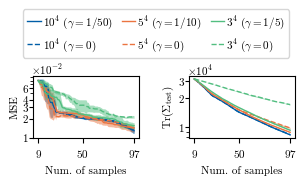

In [27]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

a = 9 
b = 89 + 9

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu10_g50, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu10_g50, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#005EA7', label=r'$10^4$ ($\gamma=1/50$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu10_g0, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu10_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#005EA7', label=r'$10^4$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu5_g10, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu5_g10, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#EB7440', label=r'$5^4$ ($\gamma=1/10$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu5_g0, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu5_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#EB7440', label=r'$5^4$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu3_g5, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu3_g5, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#52BE80', label=r'$3^4$ ($\gamma=1/5$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#52BE80', linewidth=0, alpha=0.5)

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu3_g0, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu3_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#52BE80', label=r'$3^4$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#52BE80', linewidth=0, alpha=0.5)


# -- BED k=1 -- #

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu10_g50, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu10_g50, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#005EA7')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu10_g0, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu10_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#005EA7', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#005EA7', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu5_g10, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu5_g10, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#EB7440')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu5_g0, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu5_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#EB7440', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu3_g5, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu3_g5, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#52BE80')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#52BE80', linewidth=0, alpha=0.5)

mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu3_g0, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu3_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#52BE80', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#52BE80', linewidth=0, alpha=0.5)

ax[0].legend(handlelength=1.2, ncol=3, columnspacing=0.8, handletextpad=0.2, loc=(-0.1, 1.3))

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].set_ylabel("MSE", labelpad=2)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")
    ax[i].set_xticks([9, 50, 97])
    ax[i].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[i].tick_params(axis='y', length=3, pad=1)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_yticks(np.array([1, 2, 3, 4, 6])/100)
ax[0].set_yticklabels(np.array([1, 2, 3, 4, 6]))
ax[0].text(2, 0.1, r"$\times 10^{-2}$")
ax[1].set_yticks(np.array([1, 2, 3])*10000)
ax[1].set_yticklabels(np.array([1, 2, 3]))
ax[1].text(2, 35000, r"$\times 10^{4}$")

plt.savefig("hep4d_BED_regGP_XuChoice.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)

plt.show()

# Figure 17 (b)

In [22]:
def BED_derGP(X_util_dim, gamma, n):
    # -- Utility input --------------------------------------------------------- #
    lin = np.linspace(X_lower, X_upper, X_util_dim)
    nuJ1_in, nuJ1_out, nuJ23_in, nuJ23_out = np.meshgrid(lin, lin, lin, lin)
    X_util = np.vstack((nuJ1_in.flatten(), nuJ1_out.flatten(), 
                        nuJ23_in.flatten(), nuJ23_out.flatten())).T
    # -------------------------------------------------------------------------- #

    gp_der_mse = np.zeros((n, 89))
    gp_der_uncert = np.zeros((n, 89))

    for i in range(n):
        kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
        gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42+i)
        gp_der.fit(X_train, y_train, X_train, dy_train)

        y_pred, std = batch_predict(gp_der, X_test)
        gp_der_mse[i, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_der_uncert[i, 0] = np.sum(std.ravel()**2)

        params_dicc = {'nuJ1_in': (X_lower, X_upper), 'nuJ1_out': (X_lower, X_upper),
                       'nuJ23_in': (X_lower, X_upper), 'nuJ23_out': (X_lower, X_upper)}
        BED_der = GPUncertaintyOptimizer(
            gp_model=gp_der,
            bounds=params_dicc,
            function=efficiency_events,
            der_function=der_efficiency_events_sigmoid10,
            random_state=42+i,
            verbose=False,
        )

        for j in range(88):
            gp_der = BED_der.minimize_variance(
                X_util=X_util, n_iters=1, n_restarts_optimizer=n_restarts_optimizer, gamma=gamma,
            )
            y_pred, std = batch_predict(gp_der, X_test)
            gp_der_mse[i, j+1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
            gp_der_uncert[i, j+1] = np.sum(std.ravel()**2)
    return gp_der_mse, gp_der_uncert
    

In [23]:
# gp_der_mse_Xu3_g5, gp_der_uncert_Xu3_g5 = BED_derGP(X_util_dim=3, gamma=np.sqrt(1/5), n=5)
# gp_der_mse_Xu3_g0, gp_der_uncert_Xu3_g0 = BED_derGP(X_util_dim=3, gamma=0, n=5)

# gp_der_mse_Xu5_g10, gp_der_uncert_Xu5_g10 = BED_derGP(X_util_dim=5, gamma=np.sqrt(1/10), n=5)
# gp_der_mse_Xu5_g0, gp_der_uncert_Xu5_g0 = BED_derGP(X_util_dim=5, gamma=0, n=5)

# gp_der_mse_Xu10_g50, gp_der_uncert_Xu10_g50 = BED_derGP(X_util_dim=10, gamma=np.sqrt(1/50), n=5)
# gp_der_mse_Xu10_g0, gp_der_uncert_Xu10_g0 = BED_derGP(X_util_dim=10, gamma=0, n=5)

In [24]:
# f = h5py.File("./gp_der_mse_uncert.h5", "w")
# # X_util_dim = 3
# f.create_dataset("gp_der_mse_Xu3_g5", data=gp_der_mse_Xu3_g5)
# f.create_dataset("gp_der_uncert_Xu3_g5", data=gp_der_uncert_Xu3_g5)
# f.create_dataset("gp_der_mse_Xu3_g0", data=gp_der_mse_Xu3_g0)
# f.create_dataset("gp_der_uncert_Xu3_g0", data=gp_der_uncert_Xu3_g0)
# # X_util_dim = 5
# f.create_dataset("gp_der_mse_Xu5_g10", data=gp_der_mse_Xu5_g10)
# f.create_dataset("gp_der_uncert_Xu5_g10", data=gp_der_uncert_Xu5_g10)
# f.create_dataset("gp_der_mse_Xu5_g0", data=gp_der_mse_Xu5_g0)
# f.create_dataset("gp_der_uncert_Xu5_g0", data=gp_der_uncert_Xu5_g0)
# # X_util_dim = 10
# f.create_dataset("gp_der_mse_Xu10_g50", data=gp_der_mse_Xu10_g50)
# f.create_dataset("gp_der_uncert_Xu10_g50", data=gp_der_uncert_Xu10_g50)
# f.create_dataset("gp_der_mse_Xu10_g0", data=gp_der_mse_Xu10_g0)
# f.create_dataset("gp_der_uncert_Xu10_g0", data=gp_der_uncert_Xu10_g0)
# f.close()

In [25]:
f = h5py.File("./gp_der_mse_uncert.h5", "r")
gp_der_mse_Xu3_g5 = np.array(f["gp_der_mse_Xu3_g5"])
gp_der_uncert_Xu3_g5 = np.array(f["gp_der_uncert_Xu3_g5"])
gp_der_mse_Xu3_g0 = np.array(f["gp_der_mse_Xu3_g0"])
gp_der_uncert_Xu3_g0 = np.array(f["gp_der_uncert_Xu3_g0"])
gp_der_mse_Xu5_g10 = np.array(f["gp_der_mse_Xu5_g10"])
gp_der_uncert_Xu5_g10 = np.array(f["gp_der_uncert_Xu5_g10"])
gp_der_mse_Xu5_g0 = np.array(f["gp_der_mse_Xu5_g0"])
gp_der_uncert_Xu5_g0 = np.array(f["gp_der_uncert_Xu5_g0"])
gp_der_mse_Xu10_g50 = np.array(f["gp_der_mse_Xu10_g50"])
gp_der_uncert_Xu10_g50 = np.array(f["gp_der_uncert_Xu10_g50"])
gp_der_mse_Xu10_g0 = np.array(f["gp_der_mse_Xu10_g0"])
gp_der_uncert_Xu10_g0 = np.array(f["gp_der_uncert_Xu10_g0"])
f.close()

/tmp/ipykernel_1523630/1465807971.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_der_mse_Xu3_g5 = np.array(f["gp_der_mse_Xu3_g5"])
/tmp/ipykernel_1523630/1465807971.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_der_uncert_Xu3_g5 = np.array(f["gp_der_uncert_Xu3_g5"])
/tmp/ipykernel_1523630/1465807971.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_der_mse_Xu3_g0 = np.array(f["gp_der_mse_Xu3_g0"])
/tmp/ipykernel_1523630/1465807971.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_der_uncert_Xu3_g0 = np.array(f["gp_der_uncert_Xu3_g0"])
/tmp/ipykernel_1523630/1465807971.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and 

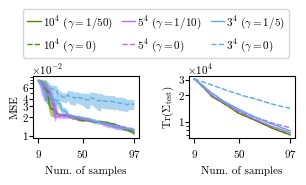

In [28]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2,    figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

a = 9 
b = 89 + 9

mean_mse_der_sequential = np.mean(gp_der_mse_Xu10_g50, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu10_g50, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#538900', label=r'$10^4$ ($\gamma=1/50$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu10_g0, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu10_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#538900', label=r'$10^4$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu5_g10, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu5_g10, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#B66EF5', label=r'$5^4$ ($\gamma=1/10$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu5_g0, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu5_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#B66EF5', label=r'$5^4$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu3_g5, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu3_g5, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#5DADE2', label=r'$3^4$ ($\gamma=1/5$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#5DADE2', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu3_g0, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu3_g0, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#5DADE2', label=r'$3^4$ ($\gamma=0$)', linestyle='--')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#5DADE2', linewidth=0, alpha=0.5)


# -- BED k=1 -- #
mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu10_g50, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu10_g50, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#538900')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu10_g0, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu10_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#538900', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#538900', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu5_g10, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu5_g10, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#B66EF5')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu5_g0, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu5_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#B66EF5', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu3_g5, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu3_g5, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#5DADE2')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#5DADE2', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu3_g0, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu3_g0, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#5DADE2', linestyle='--')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#5DADE2', linewidth=0, alpha=0.5)

ax[0].legend(handlelength=1.2, ncol=3, columnspacing=0.8, handletextpad=0.2, loc=(-0.1, 1.3))

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].set_ylabel("MSE", labelpad=2)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")
    ax[i].set_xticks([9, 50, 97])
    ax[i].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[i].tick_params(axis='y', length=3, pad=1)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_yticks(np.array([1, 2, 3, 4, 6])/100)
ax[0].set_yticklabels(np.array([1, 2, 3, 4, 6]))
ax[0].text(2, 0.1, r"$\times 10^{-2}$")
ax[1].set_yticks(np.array([1, 2, 3])*10000)
ax[1].set_yticklabels(np.array([1, 2, 3]))
ax[1].text(2, 35000, r"$\times 10^{4}$")

plt.savefig("hep4d_BED_derGP_XuChoice.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)

plt.show()

# Figure 17 (c)

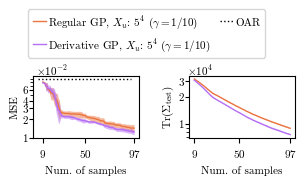

In [32]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

a = 9
b = 89 + 9

mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu5_g10, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu5_g10, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#EB7440', label=r'Regular GP, $X_u$: $5^4$ ($\gamma=1/10$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_mse_der_sequential = np.mean(gp_der_mse_Xu5_g10, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu5_g10, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#B66EF5', label=r'Derivative GP, $X_u$: $5^4$ ($\gamma=1/10$)')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

ax[0].hlines(mse_OAR, 4.5, 94, color='black', linestyle='dotted', linewidth=1, label=r'OAR')


mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu5_g10, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu5_g10, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#EB7440')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu5_g10, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu5_g10, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#B66EF5')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")


ax[0].legend(handlelength=1.2, ncol=2, columnspacing=0.8, handletextpad=0.2, loc=(-0.05, 1.3))

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].set_ylabel("MSE", labelpad=2)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")
    ax[i].set_xticks([9, 50, 97])
    ax[i].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[i].tick_params(axis='y', length=3, pad=1)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_yticks(np.array([1, 2, 3, 4, 6])/100)
ax[0].set_yticklabels(np.array([1, 2, 3, 4, 6]))
ax[0].text(2, 0.105, r"$\times 10^{-2}$")
ax[1].set_yticks(np.array([1, 2, 3])*10000)
ax[1].set_yticklabels(np.array([1, 2, 3]))
ax[1].text(2, 35000, r"$\times 10^{4}$")

plt.savefig("hep4d_BED_derGP_vs_regGP.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)
plt.show()

# Figure 18 (a)

In [33]:
def random_sampling_regGP(seed, n):
    np.random.seed(seed)
    gp_reg_mse = np.zeros((n, 89))
    gp_reg_uncert = np.zeros((n, 89))

    for i in range(n):
        kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
        gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42+i)
        gp_reg.fit(X_train, y_train)

        y_pred, std = batch_predict(gp_reg, X_test)
        gp_reg_mse[i, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_reg_uncert[i, 0] = np.sum(std.ravel()**2)

        X_sampled = X_train
        y_sampled = y_train
        for j in range(88):
            X_it = np.random.uniform(X_lower, X_upper, (1, X_train.shape[1]))
            y_it = efficiency_events(X_it[0])
            y_it = np.array(y_it).reshape(-1,)
            X_sampled = np.concatenate((X_sampled, X_it), axis=0)
            y_sampled = np.concatenate((y_sampled, y_it), axis=0)
            gp_reg.fit(X_sampled, y_sampled)
            y_pred, std = batch_predict(gp_reg, X_test)
            gp_reg_mse[i, j+1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
            gp_reg_uncert[i, j+1] = np.sum(std.ravel()**2)
    return gp_reg_mse, gp_reg_uncert

In [34]:
def grid_sampling_regGP():
    gp_reg_mse = np.zeros((1, 3))
    gp_reg_uncert = np.zeros((1, 3))

    kernel = RegularKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level)
    gp_reg = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
    gp_reg.fit(X_train, y_train)

    y_pred, std = batch_predict(gp_reg, X_test)
    gp_reg_mse[0, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
    gp_reg_uncert[0, 0] = np.sum(std.ravel()**2)

    X_sampled = X_train
    y_sampled = y_train

    for i in range(2, 4):
        ln = np.linspace(np.repeat(X_lower, 4), np.repeat(X_upper, 4), num=i)
        X_it = np.array(np.meshgrid(*ln.T)).reshape(4, i**4).T
        y_it = Pool(cpu_count()).map(efficiency_events, X_it)
        y_it = np.array(y_it).reshape(-1,)
        X_sampled = np.concatenate((X_train, X_it), axis=0)
        y_sampled = np.concatenate((y_train, y_it), axis=0)

        gp_reg.fit(X_sampled, y_sampled)
        y_pred, std = batch_predict(gp_reg, X_test)
        gp_reg_mse[0, i-1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_reg_uncert[0, i-1] = np.sum(std.ravel()**2)
    return gp_reg_mse, gp_reg_uncert

In [35]:
# gp_reg_mse_random, gp_reg_uncert_random = random_sampling_regGP(seed=42, n=5)
# gp_reg_mse_grid, gp_reg_uncert_grid = grid_sampling_regGP()

In [37]:
# f = h5py.File("./gp_reg_mse_uncert.h5", "a")
# f.create_dataset("gp_reg_mse_random", data=gp_reg_mse_random)
# f.create_dataset("gp_reg_uncert_random", data=gp_reg_uncert_random)
# f.create_dataset("gp_reg_mse_grid", data=gp_reg_mse_grid)
# f.create_dataset("gp_reg_uncert_grid", data=gp_reg_uncert_grid)
# f.close()

In [38]:
f = h5py.File("./gp_reg_mse_uncert.h5", "r")
gp_reg_mse_random = np.array(f["gp_reg_mse_random"])
gp_reg_uncert_random = np.array(f["gp_reg_uncert_random"])
gp_reg_mse_grid = np.array(f["gp_reg_mse_grid"])
gp_reg_uncert_grid = np.array(f["gp_reg_uncert_grid"])
f.close()

/tmp/ipykernel_1523630/3307893896.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_reg_mse_random = np.array(f["gp_reg_mse_random"])
/tmp/ipykernel_1523630/3307893896.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_reg_uncert_random = np.array(f["gp_reg_uncert_random"])
/tmp/ipykernel_1523630/3307893896.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_reg_mse_grid = np.array(f["gp_reg_mse_grid"])
/tmp/ipykernel_1523630/3307893896.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_reg_uncert_grid = np.array(f["gp_reg_uncert_grid"])


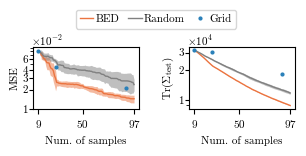

In [41]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

a = 9
b = 89 + 9

# -- MSE -- #
mean_mse_reg_sequential = np.mean(gp_reg_mse_Xu5_g10, axis=0)
std_mse_reg_sequential = np.std(gp_reg_mse_Xu5_g10, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_sequential, linewidth=1, color='#EB7440', label=r'BED')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_sequential-std_mse_reg_sequential, 
                   mean_mse_reg_sequential+std_mse_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_mse_reg_random = np.mean(gp_reg_mse_random, axis=0)
std_mse_reg_random = np.std(gp_reg_mse_random, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_reg_random, linewidth=1, color='gray', label=r'Random')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_reg_random-std_mse_reg_random, 
                   mean_mse_reg_random+std_mse_reg_random,
                   color='gray', linewidth=0, alpha=0.5)

ax[0].plot(np.array([9+i**4 for i in [0, 2, 3]]), gp_reg_mse_grid.ravel(), label='Grid', 
           color='#2980B9', zorder=5, linewidth=0, marker='o', ms=2)

# -- Uncert -- $
mean_uncert_reg_sequential = np.mean(gp_reg_uncert_Xu5_g10, axis=0)
std_uncert_reg_sequential = np.std(gp_reg_uncert_Xu5_g10, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_sequential, linewidth=1, color='#EB7440', label=r'BED')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_sequential-std_uncert_reg_sequential, 
                   mean_uncert_reg_sequential+std_uncert_reg_sequential,
                   color='#EB7440', linewidth=0, alpha=0.5)

mean_uncert_reg_random = np.mean(gp_reg_uncert_random, axis=0)
std_uncert_reg_random = np.std(gp_reg_uncert_random, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_reg_random, linewidth=1, color='gray', label=r'Random')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_reg_random-std_uncert_reg_random, 
                   mean_uncert_reg_random+std_uncert_reg_random,
                   color='gray', linewidth=0, alpha=0.5)

ax[1].plot(np.array([9+i**4 for i in [0, 2, 3]]), gp_reg_uncert_grid.ravel(), label='Grid', 
           color='#2980B9', zorder=5, linewidth=0, marker='o', ms=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].legend(handlelength=1.2, ncol=3, columnspacing=0.8, handletextpad=0.2, loc=(0.4, 1.3))

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].set_ylabel("MSE", labelpad=2)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")
    ax[i].set_xticks([9, 50, 97])
    ax[i].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[i].tick_params(axis='y', length=3, pad=1)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_yticks(np.array([1, 2, 3, 4, 6])/100)
ax[0].set_yticklabels(np.array([1, 2, 3, 4, 6]))
ax[0].text(2, 0.1, r"$\times 10^{-2}$")
ax[1].set_yticks(np.array([1, 2, 3])*10000)
ax[1].set_yticklabels(np.array([1, 2, 3]))
ax[1].text(2, 35000, r"$\times 10^{4}$")

plt.savefig("hep4d_BED_regGP_vs_all.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)

plt.show()

# Figure 18 (b)

In [42]:
def random_sampling_derGP(seed, n):
    np.random.seed(seed)
    gp_der_mse = np.zeros((n, 89))
    gp_der_uncert = np.zeros((n, 89))

    for i in range(n):
        kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
        gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42+i)
        gp_der.fit(X_train, y_train, X_train, dy_train)

        y_pred, std = batch_predict(gp_der, X_test)
        gp_der_mse[i, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_der_uncert[i, 0] = np.sum(std.ravel()**2)

        X_sampled = X_train
        y_sampled = y_train
        dy_sampled = dy_train
        for j in range(88):
            X_it = np.random.uniform(X_lower, X_upper, (1, X_train.shape[1]))
            y_it = efficiency_events(X_it[0])
            y_it = np.array(y_it).reshape(-1,)
            dy_it = der_efficiency_events_sigmoid10(X_it[0])
            dy_it = np.array(dy_it).reshape(-1, 4)
            X_sampled = np.concatenate((X_sampled, X_it), axis=0)
            y_sampled = np.concatenate((y_sampled, y_it), axis=0)
            dy_sampled = np.concatenate((dy_sampled, dy_it), axis=0)
            gp_der.fit(X_sampled, y_sampled, X_sampled, dy_sampled)
            y_pred, std = batch_predict(gp_der, X_test)
            gp_der_mse[i, j+1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
            gp_der_uncert[i, j+1] = np.sum(std.ravel()**2)
    return gp_der_mse, gp_der_uncert

In [43]:
def grid_sampling_derGP():
    gp_der_mse = np.zeros((1, 3))
    gp_der_uncert = np.zeros((1, 3))

    kernel = DerivativeKernel(amplitude=amplitude, length_scale=length_scale, noise_level=noise_level, noise_level_der=noise_level_der)
    gp_der = GaussianProcessRegressor(kernel=kernel, optimizer=None, random_state=42)
    gp_der.fit(X_train, y_train, X_train, dy_train)

    y_pred, std = batch_predict(gp_der, X_test)
    gp_der_mse[0, 0] = np.mean((y_test.ravel() - y_pred.ravel())**2)
    gp_der_uncert[0, 0] = np.sum(std.ravel()**2)

    X_sampled = X_train
    y_sampled = y_train
    dy_sampled = dy_train

    for i in range(2, 4):
        ln = np.linspace(np.repeat(X_lower, 4), np.repeat(X_upper, 4), num=i)
        X_it = np.array(np.meshgrid(*ln.T)).reshape(4, i**4).T
        y_it = Pool(cpu_count()).map(efficiency_events, X_it)
        y_it = np.array(y_it).reshape(-1,)
        dy_it = Pool(cpu_count()).map(der_efficiency_events_sigmoid10, X_it)
        dy_it = np.array(dy_it).reshape(-1, 4)
        X_sampled = np.concatenate((X_train, X_it), axis=0)
        y_sampled = np.concatenate((y_train, y_it), axis=0)
        dy_sampled = np.concatenate((dy_train, dy_it), axis=0)

        gp_der.fit(X_sampled, y_sampled, X_sampled, dy_sampled)
        y_pred, std = batch_predict(gp_der, X_test)
        gp_der_mse[0, i-1] = np.mean((y_test.ravel() - y_pred.ravel())**2)
        gp_der_uncert[0, i-1] = np.sum(std.ravel()**2)
    return gp_der_mse, gp_der_uncert

In [44]:
# gp_der_mse_random, gp_der_uncert_random = random_sampling_derGP(seed=42, n=5)
# gp_der_mse_grid, gp_der_uncert_grid = grid_sampling_derGP()

In [45]:
# f = h5py.File("./gp_der_mse_uncert.h5", "a")
# f.create_dataset("gp_der_mse_random", data=gp_der_mse_random)
# f.create_dataset("gp_der_uncert_random", data=gp_der_uncert_random)
# f.create_dataset("gp_der_mse_grid", data=gp_der_mse_grid)
# f.create_dataset("gp_der_uncert_grid", data=gp_der_uncert_grid)
# f.close()

In [46]:
f = h5py.File("./gp_der_mse_uncert.h5", "r")
gp_der_mse_random = np.array(f["gp_der_mse_random"])
gp_der_uncert_random = np.array(f["gp_der_uncert_random"])
gp_der_mse_grid = np.array(f["gp_der_mse_grid"])
gp_der_uncert_grid = np.array(f["gp_der_uncert_grid"])
f.close()

/tmp/ipykernel_1523630/2969633835.py:2: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_der_mse_random = np.array(f["gp_der_mse_random"])
/tmp/ipykernel_1523630/2969633835.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_der_uncert_random = np.array(f["gp_der_uncert_random"])
/tmp/ipykernel_1523630/2969633835.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_der_mse_grid = np.array(f["gp_der_mse_grid"])
/tmp/ipykernel_1523630/2969633835.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  gp_der_uncert_grid = np.array(f["gp_der_uncert_grid"])


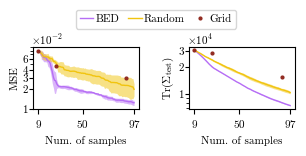

In [50]:
plt.rcParams.update({'text.usetex': False,
                     'font.family': 'serif',
                     'font.size': 8,
                     'font.serif': 'cmr10',
                     'mathtext.fontset': 'cm',
                     'axes.formatter.use_mathtext': True})

fig, ax = plt.subplots(1, 2, figsize=(3+3/8, 0.8))
plt.subplots_adjust(wspace=0.48)

a = 9
b = 89 + 9

# -- MSE -- #
mean_mse_der_sequential = np.mean(gp_der_mse_Xu5_g10, axis=0)
std_mse_der_sequential = np.std(gp_der_mse_Xu5_g10, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_sequential, linewidth=1, color='#B66EF5', label=r'BED')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_sequential-std_mse_der_sequential, 
                   mean_mse_der_sequential+std_mse_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

mean_mse_der_random = np.mean(gp_der_mse_random, axis=0)
std_mse_der_random = np.std(gp_der_mse_random, ddof=1, axis=0)
ax[0].plot(np.arange(a, b), mean_mse_der_random, linewidth=1, color='#F1C40F', label=r'Random')
ax[0].fill_between(np.arange(a, b), 
                   mean_mse_der_random-std_mse_der_random, 
                   mean_mse_der_random+std_mse_der_random,
                   color='#F1C40F', linewidth=0, alpha=0.5)

ax[0].plot(np.array([9+i**4 for i in [0, 2, 3]]), gp_der_mse_grid.ravel(), label='Grid', color='#922B21', zorder=5, linewidth=0, marker='o', ms=2)

# -- Uncert -- $
mean_uncert_der_sequential = np.mean(gp_der_uncert_Xu5_g10, axis=0)
std_uncert_der_sequential = np.std(gp_der_uncert_Xu5_g10, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_sequential, linewidth=1, color='#B66EF5', label=r'BED')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_sequential-std_uncert_der_sequential, 
                   mean_uncert_der_sequential+std_uncert_der_sequential,
                   color='#B66EF5', linewidth=0, alpha=0.5)

mean_uncert_der_random = np.mean(gp_der_uncert_random, axis=0)
std_uncert_der_random = np.std(gp_der_uncert_random, ddof=1, axis=0)
ax[1].plot(np.arange(a, b), mean_uncert_der_random, linewidth=1, color='#F1C40F', label=r'Random')
ax[1].fill_between(np.arange(a, b), 
                   mean_uncert_der_random-std_uncert_der_random, 
                   mean_uncert_der_random+std_uncert_der_random,
                   color='#F1C40F', linewidth=0, alpha=0.5)

ax[1].plot(np.array([9+i**4 for i in [0, 2, 3]]), gp_der_uncert_grid.ravel(), label='Grid', color='#922B21', zorder=5, linewidth=0, marker='o', ms=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].legend(handlelength=1.2, ncol=3, columnspacing=0.8, handletextpad=0.2, loc=(0.4, 1.3))

for i in range(2):
    ax[i].set_xlabel("Num. of samples")

ax[0].set_ylabel("MSE", labelpad=2)
ax[1].set_ylabel("Tr($\Sigma_{\mathrm{test}}$)", labelpad=2)

for i in range(2):
    ax[i].set_xlabel("Num. of samples")
    ax[i].set_xticks([9, 50, 97])
    ax[i].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    ax[i].tick_params(axis='y', length=3, pad=1)

ax[0].set_yscale('log')
ax[1].set_yscale('log')

ax[0].set_yticks(np.array([1, 2, 3, 4, 6])/100)
ax[0].set_yticklabels(np.array([1, 2, 3, 4, 6]))
ax[0].text(2, 0.1, r"$\times 10^{-2}$")
ax[1].set_yticks(np.array([1, 2, 3])*10000)
ax[1].set_yticklabels(np.array([1, 2, 3]))
ax[1].text(2, 35000, r"$\times 10^{4}$")

plt.savefig("hep4d_BED_derGP_vs_all.pdf", bbox_inches="tight", pad_inches=0.1, dpi=400)

plt.show()